# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [1]:
!pip install mysql-connector-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 32.4 MB/s eta 0:00:00


2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [31]:
import mysql.connector
print("MySQL Connector installed successfully!")

try:
    con = mysql.connector.connect(
        user='user1',
        password='7oygWy6P',
        host='3.68.62.36',
        database='employees'
    )
    print("Successfully connected to the database!")

except mysql.connector.Error as err:
    print(f"Error: {err}")


MySQL Connector installed successfully!
Successfully connected to the database!


In [32]:
# quick check to verify everything is working:
cursor = con.cursor()
cursor.execute("SELECT database();")
db_name = cursor.fetchone()
print(f"Connected to database: {db_name[0]}")


Connected to database: employees


3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [33]:
cursor = con.cursor()

query = """
SELECT
    MAX(hire_date),
    MIN(hire_date)
FROM employees;
"""

cursor.execute(query)
results = cursor.fetchall()
print(results)

cursor.close()

[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]


True

Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП.

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [14]:
field_names = [i[0] for i in cursor.description]

In [34]:
import pandas as pd
# Step 1. SQL query
cursor = con.cursor()

query = """
WITH RankedSalaries AS (
    SELECT
        emp_no,
        salary,
        from_date,
        to_date,
        ROW_NUMBER() OVER (PARTITION BY emp_no ORDER BY to_date DESC, from_date DESC) as rn
    FROM salaries
)
SELECT
    emp_no,
    salary,
    from_date,
    to_date
FROM RankedSalaries
WHERE rn = 1
ORDER BY emp_no;
"""

cursor.execute(query)

# Step 2. Get field names directly from cursor description
field_names = [i[0] for i in cursor.description]

# Step 3. Fetch results and create DataFrame
results = cursor.fetchall()
res = pd.DataFrame(results, columns=field_names)

# Step 4. Print results in expected format
print("Index(['emp_no', 'salary', 'from_date', 'to_date'], dtype='object')")
print(f"\n{res.shape}")
print("\n", res.head(3))

cursor.close()


Index(['emp_no', 'salary', 'from_date', 'to_date'], dtype='object')

(300024, 4)

    emp_no  salary   from_date     to_date
0   10001   88958  2002-06-22  9999-01-01
1   10002   72527  2001-08-02  9999-01-01
2   10003   43311  2001-12-01  9999-01-01


True

Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1lNvzbAebtkj3C2v-I5AE6HkMH8MTI1kA)

5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [35]:
# Solution 1.
print(res['to_date'].value_counts())


to_date
9999-01-01    240124
2000-01-19        36
2000-07-15        35
2000-05-31        34
2001-05-24        33
               ...  
1986-07-13         1
1985-06-08         1
1987-11-01         1
1988-05-16         1
1987-08-25         1
Name: count, Length: 5879, dtype: int64


In [36]:
# solution 2.
# Step 1. Check the data type of to_date column
print("Data type of to_date:", res['to_date'].dtype)

# Step 2. Count values where to_date is '9999-01-01' and where it's not
future_date_count = res[res['to_date'] == datetime.date(9999, 1, 1)].shape[0]
other_date_count = res[res['to_date'] != datetime.date(9999, 1, 1)].shape[0]

print(f"\nRecords with to_date = '9999-01-01': {future_date_count}")
print(f"Records with to_date ≠ '9999-01-01': {other_date_count}")


Data type of to_date: object

Records with to_date = '9999-01-01': 240124
Records with to_date ≠ '9999-01-01': 59900


6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

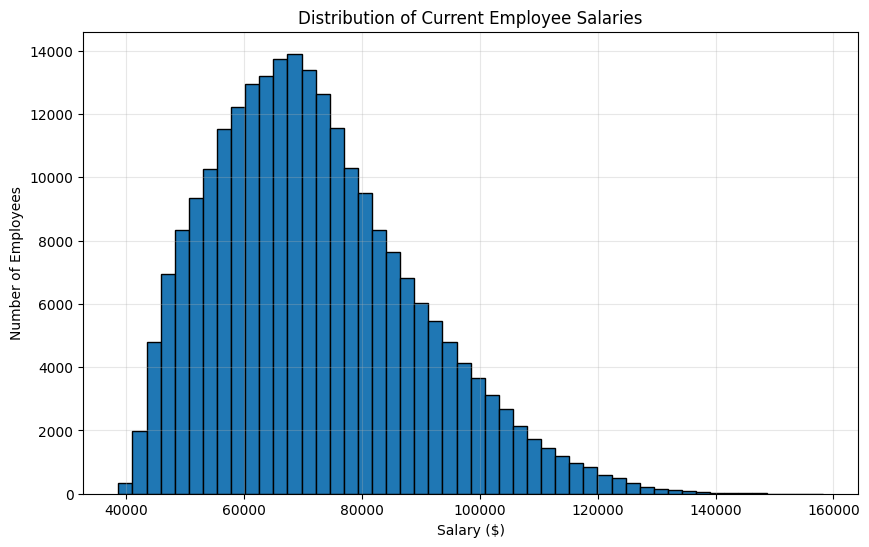

In [37]:
import matplotlib.pyplot as plt

# Step 1. Filter current employees (where to_date is '9999-01-01')
current_employees = res[res['to_date'] == datetime.date(9999, 1, 1)]

# Step 2. Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(current_employees['salary'], bins=50, edgecolor='black')

# Step 3. Add labels and title
plt.title('Distribution of Current Employee Salaries', fontsize=12)
plt.xlabel('Salary ($)', fontsize=10)
plt.ylabel('Number of Employees', fontsize=10)

# Spet 4. Add grid for better readability
plt.grid(True, alpha=0.3)

# Step 5. Show the plot
plt.show()


Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1j8MHLC1E0revbQLM9B0UJs6tVEgoWhmK)

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [22]:
con.close()